# QRAO with JijModelingTranspiler

In [1]:
import numpy as np
import networkx as nx
import qiskit as qk
import matplotlib.pyplot as plt
import jijmodeling as jm
import jijmodeling.transpiler as jmt
import jijtranspiler_qiskit as jtq

## QRAO for MaxCut
`transpiler_qiskit`では、Ising Hamiltonianだけでなく、QRAO HAmiltonianにも変換することができます。
このノートでは、実際にQRAO Hamiltonianに変換してVQEをおこなってみます。
This Algorithm is based on Fuller et al.

In [2]:
def maxcut_problem():
    # define variables
    E = jm.Placeholder('E',dim = 2)
    N = jm.Placeholder('N')
    x = jm.Binary('x', shape=N)
    e = jm.Element('e', E).set_latex('(i,j)')
    s_i = 1 - 2*x[e[0]]
    s_j = 1 - 2*x[e[1]]
    s_i.set_latex('s_i') 
    s_j.set_latex('s_j') 
    
    # set problem
    problem = jm.Problem('MAXCUT')
    problem += -1/2 * jm.Sum(e,1 - s_i*s_j)
    return problem

problem = maxcut_problem()
problem

/tmp/ipykernel_94813/1490413976.py:3: JijFutureWarning: The argument `dim` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `ndim` instead.
  E = jm.Placeholder('E',dim = 2)
/tmp/ipykernel_94813/1490413976.py:5: JijFutureWarning: The class `Binary` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `BinaryVar` instead.
  x = jm.Binary('x', shape=N)
/tmp/ipykernel_94813/1490413976.py:6: JijFutureWarning: `Element` takes 1 positional arguments in jijmodeling 1.x.x. Please use keyword arguments for extra arguments.
  e = jm.Element('e', E).set_latex('(i,j)')
/tmp/ipykernel_94813/1490413976.py:14: JijFutureWarning: The function `Sum` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `sum` instead.
  problem += -1/2 * jm.Sum(e,1 - s_i*s_j)


ここでは、例として20ノードの3regular graphを解きたいと思います。

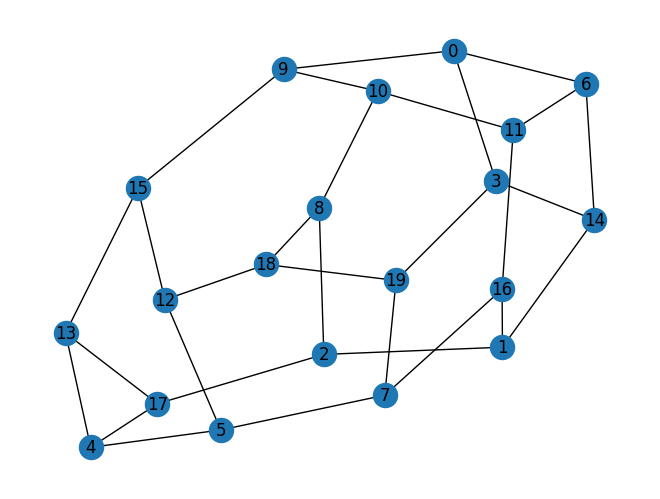

In [19]:
num_nodes = 20
G = nx.random_regular_graph(3, num_nodes)
nx.draw(G, with_labels=True)
instance_data = {'E': [list(edge) for edge in G.edges], 'N': num_nodes}

### Transpile to QRAO Hamiltonian
QRAC Hamiltonianへの変換は、Isingハミルトニアンへの変換とほぼ同じ形で行うことができます。

In [20]:
compiled_instance = jmt.core.compile_model(problem, instance_data)

qrac_builder = jtq.qrao.transpile_to_qrac31_hamiltonian(compiled_instance, normalize=False)

qrac_hamiltonian, offset, encoding_cache = qrac_builder.get_hamiltonian()

<frozen jijmodeling.transpiler.core.substitute.element_convert>:47: JijFutureWarning: `Element` takes 1 positional arguments in jijmodeling 1.x.x. Please use keyword arguments for extra arguments.


In [21]:
num_qubit = len(encoding_cache.color_group)
print(f"compression ration : {num_qubit / num_nodes}")

compression ration : 0.35


In [22]:
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Estimator, Sampler
from scipy.optimize import minimize

In [23]:
ansatz = RealAmplitudes(num_qubit, reps=1)

def cost_func(parameters, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=parameters).result().values[0]
    return cost

In [24]:
initial_params = np.random.uniform(0, 2 * np.pi, ansatz.num_parameters)
estimator = Estimator()
optimization_history = []
qrac_result = minimize(cost_func, initial_params, args=(ansatz, qrac_hamiltonian, estimator), method='BFGS',callback = lambda x:optimization_history.append(cost_func(x,ansatz, qrac_hamiltonian, estimator)))

これで、VQEの結果も得ることができました。
問題の規模が小さいので、厳密解も計算してみます。
ここでは、結果の比較のために、Ising Hamiltonianに対しても厳密解を計算してみます。

In [25]:
from qiskit.algorithms.eigensolvers import NumPyEigensolver
from jijtranspiler_qiskit.qaoa import to_ising_operator_from_qubo

In [26]:
qaoa_builder = jtq.qaoa.transpile_to_qaoa_ansatz(compiled_instance, normalize=False)
ising_hamiltonian,ising_const = qaoa_builder.get_hamiltonian()

eigen_solver = NumPyEigensolver()
result = eigen_solver.compute_eigenvalues(ising_hamiltonian)
ising_optimal = -(np.array(result.eigenvalues) + ising_const)[0].real

In [27]:
result.eigenvalues + ising_const

array([-11.+0.j])

In [28]:
ising_const

0.0

In [29]:
eigen_solver = NumPyEigensolver()
result = eigen_solver.compute_eigenvalues(qrac_hamiltonian)
qrac_optimal = -(result.eigenvalues + offset )[0].real

In [30]:
result.eigenvalues

array([-1.89236678])

得られた結果をプロットしてみます。確かに、元々のIsing HamiltonianとQRAO Hamiltonianの最大固有値の間には有限のギャップがあることがわかります。

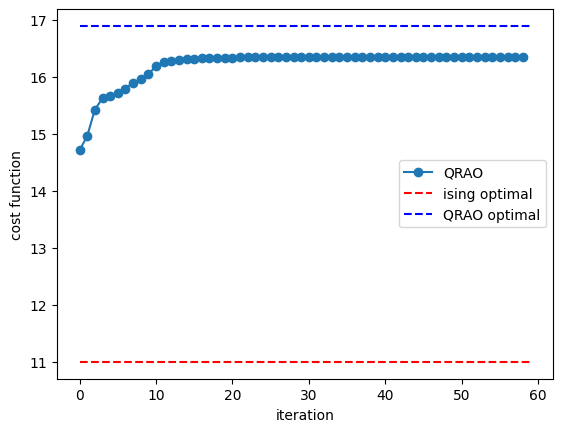

In [31]:
plt.plot(-(np.array(optimization_history) + offset),"o-", label='QRAO')
plt.plot([0, len(optimization_history)],[ising_optimal ,ising_optimal ], "red", linestyle='dashed',label = "ising optimal")
plt.plot([0, len(optimization_history)],[qrac_optimal , qrac_optimal], "blue", linestyle='dashed',label = "QRAO optimal")
plt.xlabel('iteration')
plt.ylabel('cost function')
plt.legend()

In [32]:
def pauli_rounding(ansatz,qrac_result, encoding_cache):
    encoded_op = encoding_cache.encoding
    n_qubit = len(encoding_cache.color_group)
    sorted_op = sorted(encoded_op.items())

    variable_ops = [jtq.qrao.qrao31.create_pauli_term([pauli_kind], [color], n_qubit) for idx,(color,pauli_kind) in sorted_op]

    num_variables = len(variable_ops)
    estimator = Estimator()
    estimator_result = estimator.run([ansatz] * num_variables, variable_ops, parameter_values=[qrac_result.x] * num_variables)
    
    rng = np.random.default_rng()
    def sign(val) -> int:
        return 1 if (val > 0) else 0
    rounded_vars = [sign(e) if not np.isclose(0, e) else rng.choice([0,1]) for e in estimator_result.result().values]
    return rounded_vars

In [33]:
rounding_result = pauli_rounding(ansatz,qrac_result, encoding_cache)

In [34]:
sampleset = qrac_builder.decode_from_binary_values([rounding_result])
sampleset

SampleSet(record=Record(solution={'x': [(([7, 14, 0, 18, 2, 17, 1, 13, 11, 9],), [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], (20,))]}, num_occurrences=[[1]]), evaluation=Evaluation(energy=None, objective=[-20.0], constraint_violations={}, penalty={}), measuring_time=MeasuringTime(solve=SolvingTime(preprocess=None, solve=None, postprocess=None), system=SystemTime(post_problem_and_instance_data=None, request_queue=None, fetch_problem_and_instance_data=None, fetch_result=None, deserialize_solution=None), total=None))

# Calculate gap size
次にギャップ幅の変化を調べてみます。

In [19]:
def maxcut_problem():
    # define variables
    E = jm.Placeholder('E',dim = 2)
    N = jm.Placeholder('N')
    x = jm.Binary('x', shape=N)
    e = jm.Element('e', E).set_latex('(i,j)')
    s_i = 1 - 2*x[e[0]]
    s_j = 1 - 2*x[e[1]]
    s_i.set_latex('s_i') 
    s_j.set_latex('s_j') 
    
    # set problem
    problem = jm.Problem('MAXCUT')
    problem += -1/2 * jm.Sum(e,1 - s_i*s_j)
    return problem

In [20]:
def calculate_qrac_optimal(compiled_model, multipliers={}):
    qrac_builder = jtq.qrao.transpile_to_qrac31_hamiltonian(compiled_model, normalize=False)
    qrac_hamiltonian, offset, encoding_cache = qrac_builder.get_hamiltonian(multipliers=multipliers)
    
    eigen_solver = NumPyEigensolver()
    result = eigen_solver.compute_eigenvalues(qrac_hamiltonian)
    return (np.array(result.eigenvalues) + offset )[0].real

def calculate_ising_optimal(compiled_model, multipliers={}):
    qaoa_builder = jtq.qaoa.transpile_to_qaoa_ansatz(compiled_model, normalize=False)
    ising_hamiltonian,offset = qaoa_builder.get_hamiltonian(multipliers=multipliers)

    eigen_solver = NumPyEigensolver()
    result = eigen_solver.compute_eigenvalues(ising_hamiltonian)

    return (np.array(result.eigenvalues) + offset)[0].real

def calculate_gap_size(problem,instance_data,multipliers={}):
    compiled_model = jmt.core.compile_model(problem,instance_data)
    qrao_optimal = calculate_qrac_optimal(compiled_model, multipliers=multipliers)
    ising_optimal = calculate_ising_optimal(compiled_model, multipliers=multipliers)
    return np.abs(qrao_optimal - ising_optimal), qrao_optimal, ising_optimal


In [21]:
problem = maxcut_problem()
problem

/tmp/ipykernel_89347/2603548978.py:3: JijFutureWarning: The argument `dim` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `ndim` instead.
  E = jm.Placeholder('E',dim = 2)
/tmp/ipykernel_89347/2603548978.py:5: JijFutureWarning: The class `Binary` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `BinaryVar` instead.
  x = jm.Binary('x', shape=N)
/tmp/ipykernel_89347/2603548978.py:6: JijFutureWarning: `Element` takes 1 positional arguments in jijmodeling 1.x.x. Please use keyword arguments for extra arguments.
  e = jm.Element('e', E).set_latex('(i,j)')
/tmp/ipykernel_89347/2603548978.py:14: JijFutureWarning: The function `Sum` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `sum` instead.
  problem += -1/2 * jm.Sum(e,1 - s_i*s_j)


In [22]:
bound_sizes = []
qrao_optimals = []
ising_optimals = []
for num_nodes in range(4,22,2):
    G = nx.random_regular_graph(3, num_nodes)
    instance_data = {'E': [list(edge) for edge in G.edges], 'N': num_nodes}
    gap_size,qrao_optimal,ising_optimal =  calculate_gap_size(problem,instance_data)
    bound_sizes.append(gap_size)
    qrao_optimals.append(-qrao_optimal)
    ising_optimals.append(-ising_optimal)

<frozen jijmodeling.transpiler.core.substitute.element_convert>:47: JijFutureWarning: `Element` takes 1 positional arguments in jijmodeling 1.x.x. Please use keyword arguments for extra arguments.


Text(0.5, 0, 'number of nodes')

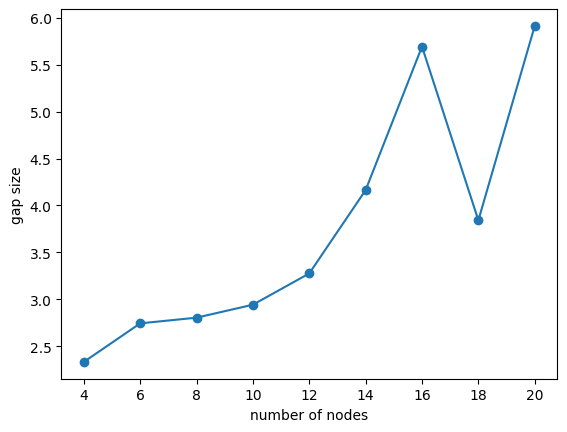

In [23]:
plt.plot(range(4,22,2),bound_sizes,"o-")
plt.ylabel("gap size")
plt.xlabel("number of nodes")

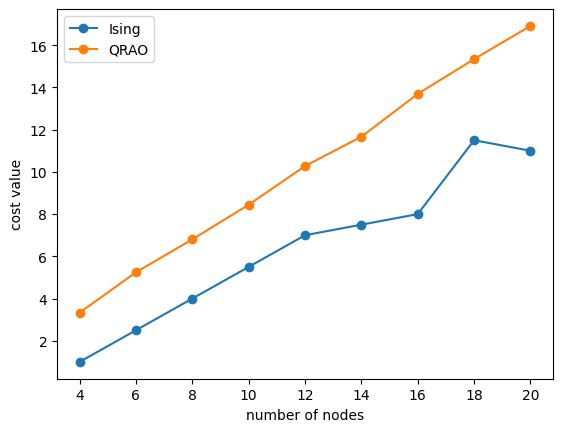

In [24]:
plt.plot(range(4,22,2),ising_optimals,"o-",label = "Ising")
plt.plot(range(4,22,2),qrao_optimals,"o-",label = "QRAO")
plt.ylabel("cost value")
plt.xlabel("number of nodes")
plt.legend()

次に、制約条件のある問題であるgraph partitionについて見てみる。

In [25]:
def graph_partition():
    # define variables
    V = jm.Placeholder('V')
    E = jm.Placeholder('E', dim=2)
    x = jm.Binary('x', shape=(V))
    u = jm.Element('u', V)
    e = jm.Element('e', E)# set problem
    problem = jm.Problem('Graph Partitioning')
    # set constraint: the vertices must be partitioined into two equal-sized sets
    const = jm.Sum(u, x[u])
    problem += jm.Constraint('constraint', const==V/2)
    # set objective function: minimize the number of edges crossing the partition
    A_1 = x[e[0]]*(1-x[e[1]])
    A_2 = (1-x[e[0]])*x[e[1]]
    problem += jm.Sum(e, (A_1 + A_2))
    return problem

In [26]:
problem = graph_partition()
problem

/tmp/ipykernel_89347/2149500668.py:4: JijFutureWarning: The argument `dim` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `ndim` instead.
  E = jm.Placeholder('E', dim=2)
/tmp/ipykernel_89347/2149500668.py:5: JijFutureWarning: The class `Binary` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `BinaryVar` instead.
  x = jm.Binary('x', shape=(V))
/tmp/ipykernel_89347/2149500668.py:6: JijFutureWarning: `Element` takes 1 positional arguments in jijmodeling 1.x.x. Please use keyword arguments for extra arguments.
  u = jm.Element('u', V)
/tmp/ipykernel_89347/2149500668.py:7: JijFutureWarning: `Element` takes 1 positional arguments in jijmodeling 1.x.x. Please use keyword arguments for extra arguments.
  e = jm.Element('e', E)# set problem
/tmp/ipykernel_89347/2149500668.py:10: JijFutureWarning: The function `Sum` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `sum` instead.
  const = jm.Sum(

In [27]:
results = {}
for penalty_value in [1,5,10]:
    bound_sizes = []
    qrao_optimals = []
    ising_optimals = []
    for num_nodes in range(4,18,2):
        G = nx.gnp_random_graph(num_nodes, 0.4)
        instance_data = {'E': [list(edge) for edge in G.edges], 'V': num_nodes}
        gap_size,qrao_optimal,ising_optimal =  calculate_gap_size(problem,instance_data,multipliers={'constraint':penalty_value})
        bound_sizes.append(gap_size)
        qrao_optimals.append(qrao_optimal)
        ising_optimals.append(ising_optimal)
        results[penalty_value] = (bound_sizes,qrao_optimals,ising_optimals)
        

<frozen jijmodeling.transpiler.core.substitute.element_convert>:47: JijFutureWarning: `Element` takes 1 positional arguments in jijmodeling 1.x.x. Please use keyword arguments for extra arguments.
<frozen jijmodeling.transpiler.core.compile.convert_to_substitutable>:24: JijFutureWarning: The argument `with_penalty` is deprecated. It will be removed when updating to jijmodeling 1.x.x.
<frozen jijmodeling.transpiler.core.compile.convert_to_substitutable>:24: JijFutureWarning: The argument `with_multiplier` is deprecated. It will be removed when updating to jijmodeling 1.x.x.
<frozen jijmodeling.transpiler.core.compile.convert_to_substitutable>:24: JijFutureWarning: The argument `auto_qubo` is deprecated. It will be removed when updating to jijmodeling 1.x.x.
<frozen jijmodeling.transpiler.core.compile.convert_to_substitutable>:24: JijFutureWarning: The argument `label` is deprecated. It will be changed when updating to jijmodeling 1.x.x. Please use `name` instead.
<frozen jijmodeling.tra

Gap幅は大きくペナルティ係数の値に依存していることがわかる。

In [28]:
print(results)

{1: ([1.3333333333333335, 5.471404520791032, 4.836139247275402, 8.130585932300118, 14.450670757512775, 19.927043559920207, 25.35540221044426], [1.6666666666666665, 1.5285954792089678, 7.663860752724598, 11.869414067699882, 15.049329242487225, 20.072956440079793, 26.14459778955574], [3.0, 7.0, 12.5, 20.0, 29.5, 40.0, 51.5]), 5: ([10.5, 27.833333333333332, 54.0, 96.16666666666667, 140.5, 190.83333333333331, 253.16666666666666], [5.0, 8.666666666666668, 14.0, 13.333333333333334, 20.000000000000004, 30.66666666666667, 39.333333333333336], [15.5, 36.5, 68.0, 109.5, 160.5, 221.5, 292.5]), 10: ([21.5, 61.166666666666664, 119.16666666666666, 198.16666666666666, 293.1666666666667, 405.5, 542.8333333333334], [8.0, 13.333333333333334, 19.333333333333336, 24.333333333333336, 33.333333333333336, 44.00000000000001, 49.66666666666667], [29.5, 74.5, 138.5, 222.5, 326.5, 449.5, 592.5])}


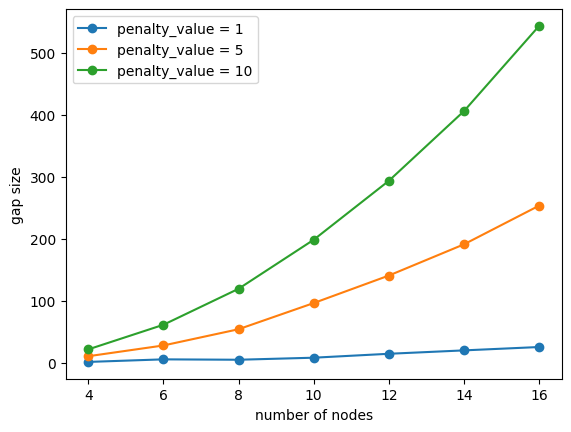

In [29]:
for key,value in results.items():
    plt.plot(range(4,18,2),np.abs(value[0]),"o-",label = f"penalty_value = {key}")
plt.ylabel("gap size")
plt.xlabel("number of nodes")
plt.legend()

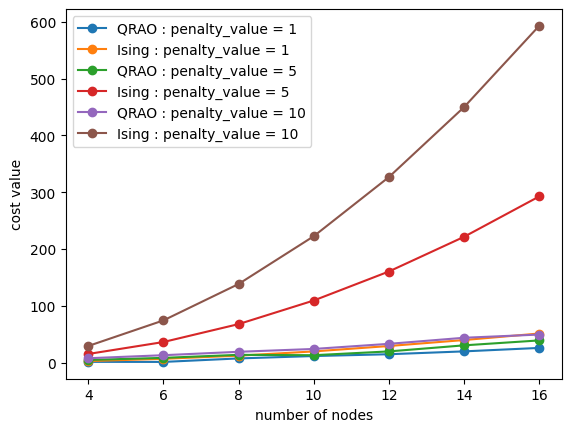

In [30]:
for key,value in results.items():
    plt.plot(range(4,18,2),value[1],"o-",label = f"QRAO : penalty_value = {key}")
    plt.plot(range(4,18,2),value[2],"o-",label = f"Ising : penalty_value = {key}")
plt.ylabel("cost value")
plt.xlabel("number of nodes")
plt.legend()